# Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [95]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from scipy.io import arff

from algo_implementation import logistic_regression
from preprocessor import Preprocessor

# library & dataset
import seaborn as sns
import matplotlib.pyplot as plt


# Dataset 1 preparation

## Preprocessing

In [4]:
def decode_bytes(x):
    """
    Function for decoding bytes-type data 
    """
    if isinstance(x, bytes):
        return x.decode()
    else:
        return x

In [5]:
preprocessor = Preprocessor()
preprocessor.remove_spaces('chronic_kidney_disease.arff', 'chronic_kidney_disease2.arff')

data, meta = arff.loadarff('chronic_kidney_disease2.arff')
dataset1 = pd.DataFrame(data)
dataset1 = dataset1.applymap(decode_bytes)
dataset1 = dataset1.replace('?', np.nan)

categorical_cols, numerical_cols = preprocessor.get_cat_num_colnames(dataset1)
binary_cols = [col for col in categorical_cols if dataset1[col].nunique(dropna=True) == 2]
multivalue_cols = list(set(categorical_cols) - set(binary_cols))
dataset1 = dataset1.drop(multivalue_cols, axis=1)


In [6]:
processed_data = preprocessor.data_preprocess(dataset1, binary_cols, numerical_cols)
X, y = processed_data.iloc[:, :-1], processed_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size = 0.2)

## Colinearity detection

### VIF

In [8]:
p = Preprocessor()
vif_coefs = p.vif(X_train)
colnames = vif_coefs[vif_coefs['VIF'] >= 10]['variables']
X_train, X_test = X_train.drop(colnames, axis=1 ), X_test.drop(colnames, axis=1 )
print(colnames)

0      age
5      sod
7     hemo
8      pcv
10    rbcc
11     rbc
12      pc
Name: variables, dtype: object


### Correlation

In [132]:
# after removing variables with VIF > 10 there are no colinear features.

corr_matrix = X_train.corr().values
np.fill_diagonal(corr_matrix, 0)
np.count_nonzero(corr_matrix > 0.8)



0

## Feature selection - PCA

[0.41618804 0.13971442 0.0979437  0.0860617  0.0686073  0.06219563
 0.05057248 0.03021032 0.01349462 0.01191551]


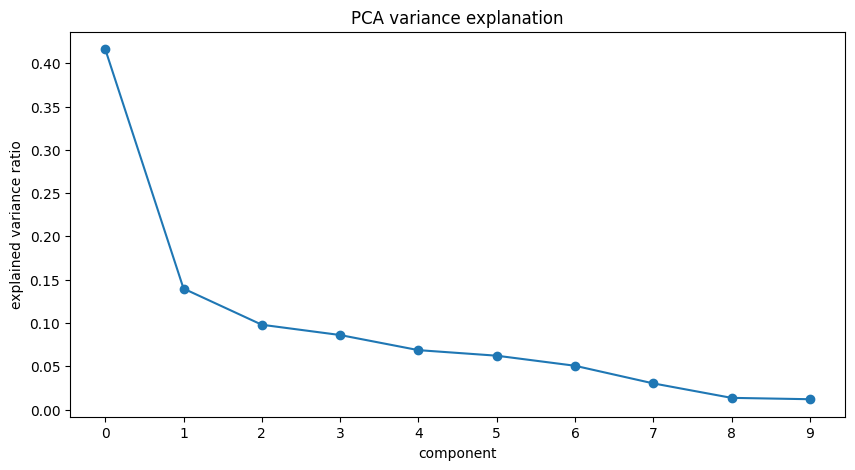

In [127]:
n_components = 10
pca = PCA(n_components=n_components)
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)

plt.figure(figsize=(10, 5))
plt.plot(range(n_components), pca.explained_variance_ratio_, marker='o')
plt.xlabel('component')
plt.ylabel('explained variance ratio')
plt.xticks(range(n_components))
plt.title('PCA variance explanation')
plt.show()

## Fit Logistic regression model

### Without regularization

In [133]:
model = logistic_regression(regularization='none')
model.fit(X_train, y_train)
accuracy = model.accuracy(X_test, y_test)
print('accuracy: {:.2f}'.format(accuracy))
print('intercept:', model.intercept_)
print('coefs', model.coef_)

accuracy: 0.95
intercept: 8.537862777282939
coefs [ -13.08817499  -16.75611016   12.11065235 -129.02866858   43.94008025
   -9.204966    -91.98470413   -0.35744579  -92.08343008  -93.30925977
   -2.05027638  -95.40356341  -95.39554244  -92.32822087]


In [100]:
model2 = LogisticRegression(penalty='none', max_iter=1000)
model2.fit(X_train, y_train)
prediction2 = model2.predict(X_test)
accuracy2 = np.sum(prediction2 == y_test)/y_test.size
print('accuracy: {:.2f}'.format(accuracy))
print('intercept:', model2.intercept_[0])
print('coefs', model2.coef_[0])

accuracy: 0.95
intercept: 8.535425755380196
coefs [ -13.08534411  -16.75016982   12.11011252 -129.03638645   43.95277652
   -9.20432193  -15.73662866   -8.66924254  -34.13775104  -35.82542753
   -3.28186673  -16.92593411  -18.27391438  -35.23263977]


### L1 regularization

In [113]:
model = logistic_regression(regularization='l1', C=0.3)
model.fit(X_train.values, y_train.values)
prediction = model.predict(X_test)
print('intercept:',model.intercept_)
print('coefs:', model.coef_)
accuracy = model.accuracy(X_test, y_test)
print('pca_accuracy: {:.2f}'.format(accuracy))

intercept: 8.50510417651965
coefs: [ -12.7332496   -16.39076901   11.77156124 -128.20110841   43.50299519
   -8.88333725  -52.36811881    0.          -39.86241051  -40.93907726
   -0.84590265  -59.2149711   -55.59756091  -38.91080319]
pca_accuracy: 0.95


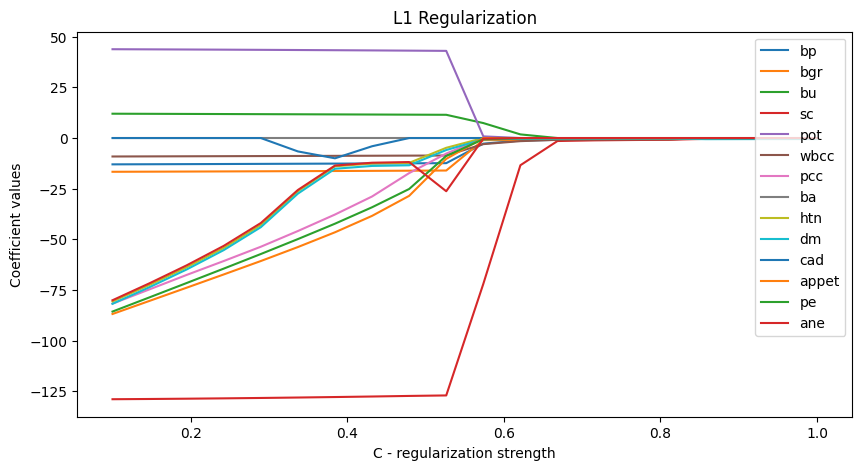

In [119]:
C_params = np.linspace(0.1, 1, num=20)
coefs = []
for C in C_params:
    m = logistic_regression(regularization='l1', C=C)
    m.fit(X_train, y_train)
    coefs.append(m.coef_)

# coefs = np.array(coefs)

# Plot the coefficients as a function of C
plt.figure(figsize=(10, 5))
plt.plot(C_params, coefs)
plt.xlabel('C - regularization strength')
plt.ylabel('Coefficient values')
plt.title('L1 Regularization')
plt.legend(X_train.columns, loc='upper right')
plt.show()


### L2 regularization

In [116]:
model = logistic_regression(regularization='l2', C=2)
model.fit(X_train, y_train)
accuracy = model.accuracy(X_test, y_test)
print('accuracy: {:.2f}'.format(accuracy))
print('intercept:', model.intercept_)
print('coefs', model.coef_)

accuracy: 0.90
intercept: 1.4965035915207419
coefs [-0.70847024 -1.0436184  -0.62360902 -0.38388987 -0.05375769 -0.62510262
 -1.09315996 -0.54181942 -1.86905326 -2.15228529 -0.48407544 -1.48704944
 -1.57217983 -1.16492271]


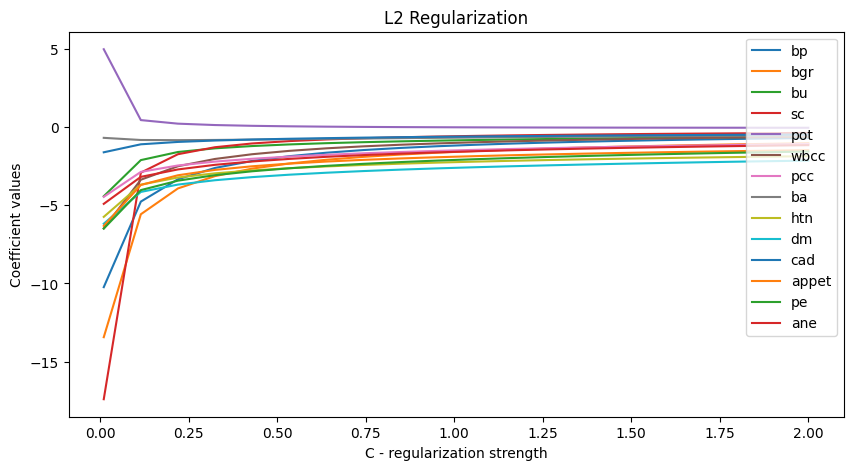

In [124]:
C_params = np.linspace(0.01, 2, num=20)
coefs = []
for C in C_params:
    m = logistic_regression(regularization='l2', C=C)
    m.fit(X_train, y_train)
    coefs.append(m.coef_)

# coefs = np.array(coefs)

# Plot the coefficients as a function of C
plt.figure(figsize=(10, 5))
plt.plot(C_params, coefs)
plt.xlabel('C - regularization strength')
plt.ylabel('Coefficient values')
plt.title('L2 Regularization')
plt.legend(X_train.columns, loc='upper right')
plt.show()

In [106]:
model2 = LogisticRegression(penalty='l2', C=1/2, max_iter=1000)
model2.fit(X_train, y_train)
prediction2 = model2.predict(X_test)
accuracy2 = np.sum(prediction2 == y_test)/y_test.size
print('accuracy: {:.2f}'.format(accuracy))
print('intercept:', model2.intercept_[0])
print('coefs', model2.coef_[0])

accuracy: 0.90
intercept: 1.4965079918838504
coefs [-0.70847866 -1.04362591 -0.62361268 -0.38390468 -0.05375089 -0.62510851
 -1.09316285 -0.5418365  -1.86905725 -2.15227907 -0.48406918 -1.48704672
 -1.57218726 -1.16492995]


## Export dataset to $.csv$

In [ ]:
kidney_disease = pd.concat([X, pd.DataFrame(y, columns=["class"])], axis=1)
kidney_disease.to_csv('kidney_disease.csv', index=False)